# SBU CSE 352 - HW 4 - Machine Learning From Scratch


Name: [Add your name]

I understand that my submission needs to be my own work: [your initials]

I understand that ChatGPT / Copilot / other AI tools are not allowed: [your initials]

---

## Instructions

Total Points: 100

1. Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy and built-in packages like random). Submit the completely rendered notebook as a HTML file.

  **Important:** Do not use scikit-learn or other packages with ML built in. The point of this is to be a learning exercise. Using linear algebra from numpy is okay (things like matrix operations or pseudoinverse, for example, but not lstsq).

2. Your notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use matplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.

## Introduction

You will implement several machine learning algorithms and evaluate their accuracy. This will be done for a downscaled version of the MNIST digit recognition dataset.

**Like in real life, some of the tasks you will be asked to do may not be possible, at least directly. In these cases, your job is to figure out why it won't work and either propose a fix (best), or provide a clear explanation why it won't work.**

For example, if the problem says to do k-nearest neighbors with a dataset of a billion points, this could require too much time to do each classification so it's infeasible to evaluate its test accuracy. In this case, you could suggest randomly downsample the data to a more manageable size, which will speed things up by may lose some accuracy. In your answer, then, you should describe the problem and how you solved it and the trade-offs.

# Data
First the code below ensures you have access to the training data (a subset of the MNIST images), consisting of 100 handwritten images of each digit.

In [2]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
!git clone https://github.com/stanleybak/CS7320-AI.git
%cd CS7320-AI/ML
!ls

Cloning into 'CS7320-AI'...
remote: Enumerating objects: 2794, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 2794 (delta 7), reused 2 (delta 2), pack-reused 2781 (from 3)
Receiving objects: 100% (2794/2794), 253.18 MiB | 31.07 MiB/s, done.
Resolving deltas: 100% (1737/1737), done.
/content/CS7320-AI/ML
line_fitting.ipynb	ML_for_tictactoe.ipynb		  README.md
mini-mnist-1000.pickle	ML_for_tictactoe_self_play.ipynb
ML_example.ipynb	MNIST.ipynb


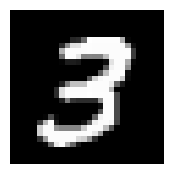

In [3]:
import matplotlib.pyplot as plt
import pickle

# if the below fails to open, then the data file is not in the current working directory (see above code block)
with open('mini-mnist-1000.pickle', 'rb') as f:
  data = pickle.load(f)

im3 = data['images'][300] # 100 images of each digit
plt.figure(figsize=(2, 2))  # Adjust size as needed
plt.imshow(im3, cmap='gray')
plt.axis('off')
plt.show()

# Downscaling Images

MNIST images are originally 28x28. We will train our models not just on the original images, but also on downscaled images with the following sizes: 14x14, 7x7, 4x4, 2x2. The next code block shows one way to do downscaling. As you can tell from the output, we cannot expect our model's accuracy will be too high on lower resolution versions, although it's unclear how much better you can do than random chance, which should have a 10% accuracy.

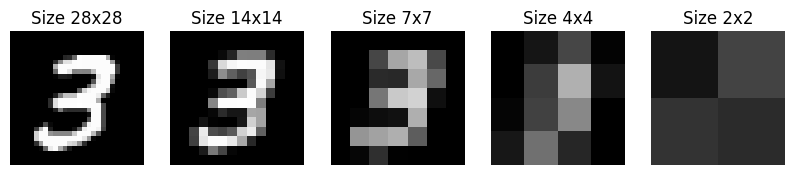

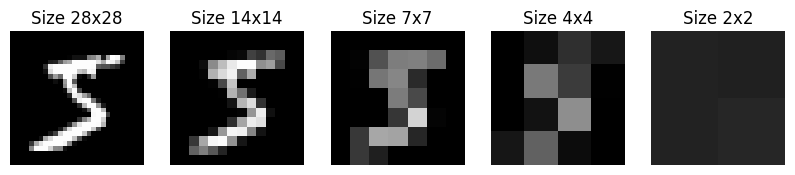

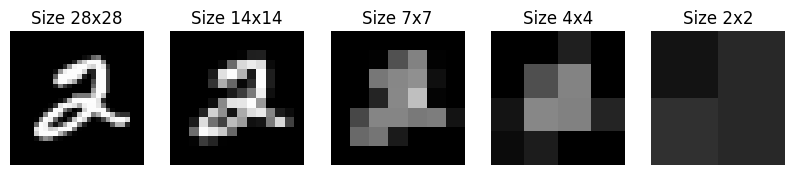

In [4]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Function to downscale an image to different sizes
def downscale_image(image, downscaled_size):
    block_size = 28 // downscaled_size
    downscaled = np.zeros((downscaled_size, downscaled_size))
    for i in range(downscaled_size):
        for j in range(downscaled_size):
            # Calculate the average for each block
            block = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            downscaled[i, j] = np.mean(block)
    return downscaled

# Load the dataset (assuming this file is in your working directory)
with open('mini-mnist-1000.pickle', 'rb') as f:
    data = pickle.load(f)

images = data['images']  # a list of 1000 numpy image matrices
labels = data['labels']  # a list of 1000 integer labels

# Select 3 "random" indices from the dataset
random_indices = [300, 500, 200]

# Downscale the images to multiple sizes and display them
sizes = [28, 14, 7, 4, 2]
for index in random_indices:
    fig, axs = plt.subplots(1, len(sizes), figsize=(10, 2))
    for ax, size in zip(axs, sizes):
        downscaled_image = downscale_image(images[index], size)
        ax.imshow(downscaled_image, cmap='gray', vmin=0, vmax=255)
        ax.set_title(f'Size {size}x{size}')
        ax.axis('off')
    plt.show()

---
# Tasks

Your data contains 100 images in each class. When training models, use 80% of training, 10% for validation and 10% for testing. Make sure the data is balanced in each class when splitting.

---
## Task 1: Linear Classifier [20 points]

First, implement a linear classifier. The simplest way to do this is to adapt linear regression approaches that we learned about in class, where the output is a real number. For classification, we can let one category be an output of 1.0 and the other -1.0. Then, after the classifier is trained we can use the sign of the output to determine the predicted class.

However, since in MNIST there are multiple classes (10 digits, not just 2), we need to adapt the approach further. We will try both of the following two popular strategies: One-vs-Rest (OvR) and One-vs-One (OvO).

**One-vs-Rest (OvR)** is a strategy for using binary classification algorithms for multiclass problems. In this approach, a separate binary classifier is trained for each class, which predicts whether an instance belongs to that class or not, making it the 'one' against all other classes (the 'rest'). For a new input instance, compute the output of all classifiers. The predicted class is the one whose corresponding classifier gives the highest output value.

**One-vs-One (OvO)** is another strategy where a binary classifier is trained for every pair of classes. If there are N classes, you will train N(N−1)/2 classifiers. For a new input, evaluate it using all N(N−1)/2​ classifiers. Count the number of times each class is predicted over all binary classifications. The class with the highest count is selected as the final prediction.

### Report Results
Report the test accuracy for OvR and OvO, for each of the input image sizes, 28x28, 14x14, 7x7, 4x4, 2x2. A table may be helpful. Also report any interesting observations.

In [5]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from itertools import combinations

# make stables reproductions
np.random.seed(0)

with open('mini-mnist-1000.pickle', 'rb') as f:
    data = pickle.load(f)

images = data['images']  # a list of 1000 numpy image matrices
labels = np.array(data['labels'])  # a list of 1000 integer labels


# split data into : 80% train, 10% validation, 10% testing
train_idx, val_idx, test_idx = [], [], []

for i in range(10):
  idx = np.where(labels == i)[0]
  np.random.shuffle(idx)
  train_idx.extend(idx[:80])
  val_idx.extend(idx[80:90])
  test_idx.extend(idx[90:100])

train_idx = np.array(train_idx)
val_idx = np.array(val_idx)
test_idx = np.array(test_idx)

def ovr(size):

  x = np.array([downscale_image(image, size).flatten() for image in images]) # all features
  y = labels # target

  # split into traing and testing
  x_train,  x_test = x[train_idx], x[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  # OvR
  weight_ovr = np.zeros((10, x_train.shape[1]))

  # train one binary classifier per class
  for i in range(10):
    y_binary = np.where(y_train == i, 1.0, -1.0)
    # Moore–Penrose pseudoinverse
    pinv_x = np.linalg.pinv(x_train)# compute sudo-inverse
    # multiply puso-inverse by y_binary
    weight_ovr[i] = np.dot(pinv_x, y_binary)

  # raw scores of the test set
  ovr_scores = np.dot(x_test, weight_ovr.T)
  # predict by choosing the hieghtest score
  y_predict_ovr = np.argmax(ovr_scores, axis=1)
  # compute accurary
  ovr_accurary = np.mean(y_predict_ovr == y_test)

  return ovr_accurary

def ovo(size):

  x = np.array([downscale_image(image, size).flatten() for image in images]) # all features
  y = labels # target

  # split into traing and testing
  x_train,  x_test = x[train_idx], x[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  # OvO
  # form all class pairs
  pairs = list(combinations(range(10), 2))
  weight_ovo = {}
  # train binary classifiers

  for i, j in pairs:
    m = (y_train == i) | (y_train == j)
    # select only the raws that has labels i or j in the traiing set
    y_pair = y_train[m]
    x_pair = x_train[m]
    # amke the the two-class label into one binary target -1, 1
    y_binary = np.where(y_pair == i, 1.0, np.where(y_pair == i, -1.0, 0.0))
    # Moore–Penrose pseudoinverse
    pinv_x = np.linalg.pinv(x_pair)
    # multiply puso-inverse by y_binary
    weight_ovo[(i,j)] = np.dot(pinv_x, y_binary)


  #predict and compute accurary
  y_predict_ovo = []
  # iterate over each feature
  for x in x_test:
    # element vote counter per digit
    vote = np.zeros(10, dtype=int)

    # iterate over each pair and the weight of each pair
    for (i, j) , w in weight_ovo.items():
      # favor the class i if its weight is positve
      winner = i if w.dot(x) > 0 else j
      # add the vote
      vote[winner]+=1

    # pick the index with the highest vote
    y_predict_ovo.append(np.argmax(vote))

  # compute accurary
  ovo_accurary = np.mean(np.array(y_predict_ovo) == y_test)

  return ovo_accurary



sizes = [28, 14, 7, 4, 2]

ovr_results = [ovr(s) * 100 for s in sizes]
ovo_results = [ovo(s) * 100 for s in sizes]
imag_size = ['28×28', '14×14', '7×7', '4×4', '2×2']

accurary_resulsts = pd.DataFrame({
    'image size' : imag_size,
    'OvR Accuracy (%)': ovr_results,
    'OvO Accuracy (%)': ovo_results
})
print(accurary_resulsts)


  image size  OvR Accuracy (%)  OvO Accuracy (%)
0      28×28              54.0              30.0
1      14×14              82.0              37.0
2        7×7              75.0              34.0
3        4×4              64.0              20.0
4        2×2              32.0              14.0


---
## Task 2: Data Augmentation [20 points]

Your boss was unhappy with the test accuracy, especially of your 2x2 image classifier, and has made some suggestions. The problem, according to your boss, is that there is not enough data in each input $x$. You are told to augment the data with derived features in order to help the classifier.

Specifically, given an input $x$, create additional attributes by computing all of the data up to powers of two. For example, in the 2x2 case your example $x$ consists of four pixel values $x_0$, $x_1$, $x_2$, and $x_3$. Your new input data would have:

* all power of zero: 1 (constant)
* all powers of one: $x_0$, $x_1$, $x_2$, $x_3$
* all powers of two:

  $x_0^2$, $x_0 x_1$, $x_0 x_2$, $x_0 x_3$,
  
  $x_1^2$, $x_1 x_2$, $ x_1 x_3$,
  
  $x_2^2$, $x_2 x_3$,
  
  $x_3^2$

The data would have 15 values, which has the potential to learn nonlinear relationships between the original inputs, which was not possible before.

### Report Results

Report the test accuracy for OvR only, with the data augmentation approach, for each of the input image sizes, 28x28, 14x14, 7x7, 4x4, 2x2 (again, perhaps incorporating a table). Report any interesting results or observations.

Also, explain to your boss what the danger is of looking at a model's final test accuracy and then suggesting changes to improve it. What should be done instead, if you know you will consider different types of models or hyperparameters in the same model class?

In [6]:
def agumentation(x):
  D = len(x)
  # constant term
  feats = [1.0]
  # linear term
  feats += list(x)
  # all quadratic terms
  for i in range(D):
      for j in range(i, D):
          feats.append(x[i]* x[j])
  return np.array(feats)

def ovr_agumentation(size):
  x_raw = np.array([downscale_image(image, size).flatten() for image in images]) # all features
  # apply the augmentation ro the raw downscale images aka features
  x = np.array([agumentation(x) for x in x_raw])
  y = labels # target

  # split into traing and testing
  x_train,  x_test = x[train_idx], x[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  # OvR
  weight_ovr = np.zeros((10, x_train.shape[1]))
  # compute sudo-inverse once for efficiency
  pinv_x = np.linalg.pinv(x_train)

  for i in range(10):
    y_binary = np.where(y_train == i, 1.0, -1.0)
    weight_ovr[i] = np.dot(pinv_x, y_binary)



  # raw scores of the test set
  ovr_scores = np.dot(x_test, weight_ovr.T)
  # predict by choosing the hieghtest score
  y_predict_ovr = np.argmax(ovr_scores, axis=1)
  # compute accurary
  ovr_accurary = np.mean(y_predict_ovr == y_test)

  return ovr_accurary


sizes = [28, 14, 7, 4, 2]
ovr_results = [ovr(s) * 100 for s in sizes]
ovr_aug_results = [ovr_agumentation(s) * 100 for s in sizes]

imag_size = ['28×28', '14×14', '7×7', '4×4', '2×2']


accurary_resulsts = pd.DataFrame({
    'image size' : imag_size,
    'OvR Accuracy (%)': ovr_results,
    'OvR Augmentation Accuracy (%)': ovr_aug_results
})
print(accurary_resulsts)



'''
Answer:

Looking at the accuracy results and changing features or modesl into out advantage to chase a higher number,
the information from the test set has been compromised leading to a over optimistic estimates on how well
the model do on unseen data. A better approch will be to include cross-validations feature engennering and
hyperparameter tunning so that the final test fold is untouch until the last model evaluation.
'''

  image size  OvR Accuracy (%)  OvR Augmentation Accuracy (%)
0      28×28              54.0                           88.0
1      14×14              82.0                           89.0
2        7×7              75.0                           34.0
3        4×4              64.0                           66.0
4        2×2              32.0                           45.0


---
## Task 3: k-Nearest Neighbors Classifier [20 points]

Your boss is still unhappy with the results (and still ignoring your advice about not using test data accuracy for model decisions).

Next, you are to use the k-nearest neighbors approach to build a classifier for our data. Since we have multiple classes, the one that gets selected can be based on a plurality vote of the $k$ closest samples (whichever category is most frequent). If there are ties, select the class based on the sum of the distances from the test point. For example, if $k=5$, and the closest 5 samples have two pictures that are from category "1" and two pictures that are from category "7", then you choose the output by computing the sum of the distance from the test point and the two "5" samples, as well as the sum of distances from the test point to the two "7" samples, and then outputting the class with the smaller total distance.

### Report Results

For each image size, exhaustively explore different values of $k$ up to 50. Report the best test accuracy. Report the average time taken to do a lookup with the model.

In [14]:
import time

def eucledian(x, x_train):
  return np.sqrt(((x_train - x) ** 2).sum(axis=1))

def KNN(size, K=50):
  x = np.array([downscale_image(image, size).flatten() for image in images]) # all features
  y = labels # target

  # split into traing and testing
  x_train,  x_test = x[train_idx], x[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]


  best_accurary = 0
  best_k = 0
  best_time = 0

  for k in range(1,K+1):
    total_time = 0
    correct = 0

    # iterate over each test sample (x, y_true)
    for x, y_true in zip(x_test, y_test):

      start = time.time()
      # eucledian distance
      d = eucledian(x, x_train)
      # sort distances from small to large
      nn = np.argsort(d)
      # only take the k first neighbors
      nn = nn[:k]
      # get the digit labels of the firs k neighbors
      digit_labels = y_train[nn]
      # plurarity vote
      # count how many votes belong to each class digit
      count = np.bincount(digit_labels, minlength=10)
      max_count = count.max()
      # get all the indices that are in the max_count
      indices = np.where(count == max_count)[0]

      # ties handeling
      if len(indices) > 1:
        # pick the class that has the smallest sum distance
        sums = { idx: d[nn][digit_labels == idx].sum()  for idx in indices}
        predicted = min(sums, key=sums.get)
      else:
        predicted = indices[0]

      # collect metrics
      end = time.time()
      total_time += end - start
      correct += (predicted == y_true)


    # compute metrics
    accurary = correct / len(y_test)
    avg_time = total_time / len(y_test)


    # update metrics
    if accurary > best_accurary:
      best_accurary = accurary
      best_k = k
      best_time = avg_time

  return best_accurary, best_k, best_time

sizes = [28, 14, 7, 4, 2]
imag_size = ['28×28', '14×14', '7×7', '4×4', '2×2']
KNN_results = [KNN(s) for s in sizes]
KNN_accurary = [r[0] * 100 for r in KNN_results]
KNN_k = [r[1] for r in KNN_results]
KNN_time = [r[2] for r in KNN_results]

accurary_results = pd.DataFrame({
    'image size' : imag_size,
    'Accurary (%)': KNN_accurary,
    'Best k': KNN_k,
    'Average time (s)': KNN_time
})
print(accurary_results)




  image size  Accurary (%)  Best k  Average time (s)
0      28×28          84.0       6          0.001704
1      14×14          89.0       4          0.000400
2        7×7          85.0       1          0.000161
3        4×4          70.0       3          0.000090
4        2×2          52.0      13          0.000074


---
## Task 4: Decision Trees [15 Points]

Your boss heard that **decision trees**, **regression trees** and **random forests** are popular in machine learning and wants to see how well they will work on the problem. Adapt one of these approaches (you don't have to do all three) in a way that allows it to make reasonable predictions for this domain, and report what you needed to do. Report your results in terms of test accuracy for the different image sizes in a table. If some of your ideas do not work, report what you tried and why not.

**Note 1**: As described in class, decision trees work on categorical attributes, so you will need to adapt things, perhaps by choosing thresholds for the continuous variables in some reasonable way. Describe your thought process and what you did.

**Note 2**: Do not use ChatGPT to do the thinking for you. Do not use `scikit-learn` or other ML libraries for this task. Using `numpy`, `scipy`, and `pandas` is okay.

**Note 3**: For splitting categorical variables in decision trees, recall from the slides that information in an answer when the prior is $ \langle P_1, \ldots, P_n \rangle $ is $H(P_1, \ldots, P_n) = -\sum_{i=1}^{n} P_i \log_2 P_i $. The suggestion was to use entropy to greedily select which attributes to split on.

**Note 4**: If you want to try random forests or regression trees, video lectures will be provided in a Brightspace announcements. Feel free to also read the book and seek online resources, but do not copy over existing code.


In [28]:

'''
- continus to binary : compare each pixel median over the training set
- splitting : each pixel will belong to a yes/no group (1-> obove the pixel median, else  -> 0)
- impurity measure:  gain = (inpurity before split ) - (weighted impurity after : corresponds to the split into yes/no group  )
      gain = (parent) - (  (right child) +  (left child))
      gain = (parent) - ( (number of samples on the yes (1) group / # of samples) * right_child ) + ( (number of samples on the no (0) group / # of samples) * left_child)
- stopping growing : depth cap, avoid expanding small groups( avoid overfitting due to the children with small data), pure nodes (all classes into one group)
- adding limitations to the grow of the tree can help avoid overfititng (specially in size like 28x28)

'''
from collections import Counter


def entropy(y):
  p = Counter(y)
  p = np.array(list(p.values())) / len(y)
  return -np.sum(p * np.log2(p + 1e-12))

class Decision_Tree:
  def __init__(self, max_depth=10, min_samples=5):
    self.max_depth = max_depth
    self.min_samples = min_samples
    self.median = None # pixel median
    self.tree = None # root

  def new_node(self, x_binary, y, depth):

    # check for stopping rules: depth cap, small groups, pure nodes
    if depth >= self.max_depth or len(y) < self.min_samples or len(np.unique(y)) == 1:
      return ('leaf', Counter(y).most_common(1)[0][0]) # pick the majority class

    impurity_before = entropy(y) # parent
    best_gain = 0
    best_feat = None
    # iterate every feature
    for i in range(x_binary.shape[1]):
      # split into group 1 and 0
      group_1 = (x_binary[:, i] == 1) # right child
      group_0 = (x_binary[:, i] == 0) # left child

      # check for small groups
      if np.sum(group_1) < self.min_samples or np.sum(group_0) < self.min_samples:
        continue

      # calculate each group entopy
      right_child = entropy(y[group_1])
      left_child = entropy(y[group_0])
      n_right = np.sum(group_1)
      n_left = np.sum(group_0)
      n = len(y)

      # compute gain
      impurity_after =  ( (n_right / n) * right_child ) + ( (n_left / n) * left_child)
      gain = impurity_before - impurity_after

      # update metrics
      if gain > best_gain:
        best_gain = gain
        best_feat = i

    # none of the features produce a pos gain
    if best_feat is None:
      return ('leaf', Counter(y).most_common(1)[0][0])

    # split again
    group_1 = (x_binary[:, best_feat] == 1) # right child
    group_0 = (x_binary[:, best_feat] == 0) # left child
    right_subtree = self.new_node(x_binary[group_1], y[group_1], depth + 1)
    left_subtree = self.new_node(x_binary[group_0], y[group_0], depth + 1)
    return ('node', best_feat, left_subtree, right_subtree)



  def fit(self, x , y):
    # compute the media of each pixel
    self.median = np.median(x, axis=0)
    # apply the binary-logic to the training set
    x_binary = (x >= self.median).astype(int)
    # build the tree
    self.tree = self.new_node(x_binary, y, depth=0)

  def predict_(self, x):
    # binary-logic to the training set
    x_binary = (x >= self.median).astype(int)
    node = self.tree # root
    while node[0] == 'node':
      node_type, feat, left, right = node
      if x_binary[feat] == 0:
        node = left
      else:
        node = right

    return node[1]


  def predict(self,X):
    return np.array([self.predict_(x) for x in X])


sizes = [28, 14, 7, 4, 2]

results = []
for size in sizes:
  x = np.array([downscale_image(image, size).flatten() for image in images]) # all features
  y = labels # target

  # split into traing and testing
  x_train,  x_test = x[train_idx], x[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  decision_tree = Decision_Tree(max_depth=10, min_samples=5)
  decision_tree.fit(x_train, y_train)
  y_predict = decision_tree.predict(x_test)
  accuracy = np.mean(y_predict == y_test)

  results.append({
        'image size': f'{size}x{size}',
        'Decisioin tree Accuracy (%)': accuracy * 100
    })


print(pd.DataFrame(results))



'''
Using median split to go from continous to binary on every pixel, gave me as many features as pixels (eg: 28x28 -> 784, 14x14 -> 196 etc).
After all pixesl were split into each group, the stopping rules prevented some samples to be expanded, specially in high resolutions (many splits with small children)

14x14 and 7x7 perpormed better than 28x28 because all features in 28x28 were not used in 10 labels(depth)
the 2x2 was too small to split into 10 classes which explains the low performance

To conclude, on high resolutions the tree didn't have enough splits (depth) before it get to use all features, which lead to underfitting. On the other side,
on small resolutions even when more splits were avilable with fewer features, the splits wee not enough. Lastly, it seems to be that the stoppings rules are
limmiting the grow (eg: min_samples=5) which blocked nodes with fewer points

improvenments:
          1) by giving each pixel multiple threshold (other than median), perhaps increasing the number of features in which the same depth=10 can explore more
          2) tweak the max_depth to a higher split (if multiple threshold was introduced)

  image size  Decisioin tree Accuracy (%)
0      28x28                         62.0
1      14x14                         69.0
2        7x7                         69.0
3        4x4                         55.0
4        2x2                         28.0


---
## Task 5: Neural Networks [25 Points]

Next, your boss wants you to try neural networks. Rather than using a library to do the training for you, you will **only** use `pytorch` to perform backpropagation and compute gradients. Using activation functions like `torch.sigmoid` or `torch.softmax` is allowed, as you need to do this for computing gradients. You can write your own high-level neural network class if desired, don't use anything from `pytorch` for that.


An example network and how to compute gradients with pytorch is shown below.


In [ ]:
# Example of using pytorch to compute gradients and updates weights and biases
#
# The network consists of:
# 1. An input layer with 3 features.
# 2. A first hidden layer with 3 neurons. Each neuron in this layer performs a linear transformation
#    on the input data using a weight matrix (W1) and a bias vector (b1). This is followed by a sigmoid
#    activation function.
# 3. A second hidden layer, also with 3 neurons, which processes the output of the first layer. Similar
#    to the first layer, it uses a weight matrix (W2) and a bias vector (b2) for linear transformation,
#    followed by a softmax activation function. The softmax activation is used here to normalize the
#    output of the second layer into a probability distribution over the three classes. This is particularly
#    useful for multi-class classification problems.
# 4. The network uses cross-entropy as the loss function, which is a common choice for classification tasks
#    involving softmax outputs. This loss function compares the predicted probability distribution with the
#    true distribution (one-hot encoded) and penalizes the predictions that diverge from the actual labels.
#


import torch

# Initialize input, weights, and biases
x = torch.tensor([1.0, 2.0, 3.0])
W1 = torch.tensor([[0.1, 0.2, 0.5],
                  [-0.1, -0.5, -1.1],
                  [0, 7.5, -1.1]], requires_grad=True)
b1 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

W2 = torch.tensor([[0.1, -0.3, 0.4],
                  [0.2, 0.4, -0.6],
                  [-0.1, 0.5, -0.2]], requires_grad=True)
b2 = torch.tensor([0.0, 0.0, 0.0], requires_grad=True)

# Target output
y_true = torch.tensor([1.0, 0.0, 0.0])

# Forward pass through first layer
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation

# Forward pass through second layer
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

print("Initial Output:", a2)
print("Desired Output:", y_true)

# Compute loss (Cross-entropy): https://en.wikipedia.org/wiki/Cross-entropy
loss = -torch.sum(y_true * torch.log(a2))
print("Initial loss:", loss.item())

# Backpropagation
loss.backward()

# you can print out gradient for each element now
print("Gradient for weights matrix W1:", W1.grad)

# Update weights and biases based on gradient (should reduce loss)
learning_rate = 0.02

# the no_grad() environment is needed to indicate that the computation should not
# be part of the gradient computation
with torch.no_grad():
    W1 -= learning_rate * W1.grad
    b1 -= learning_rate * b1.grad
    W2 -= learning_rate * W2.grad
    b2 -= learning_rate * b2.grad

# After the update, clear the gradients (in case we want to compute them again later)
W1.grad.zero_()
b1.grad.zero_()
W2.grad.zero_()
b2.grad.zero_()

# Forward pass with updated weights and biases
z1 = torch.matmul(W1, x) + b1
a1 = torch.sigmoid(z1)  # Sigmoid activation
z2 = torch.matmul(W2, a1) + b2
a2 = torch.softmax(z2, dim=0)  # Softmax activation

# Compute new loss
new_loss = -torch.sum(y_true * torch.log(a2))
print("New loss after updating weights and biases:", new_loss.item())


Initial Output: tensor([0.5348, 0.2167, 0.2485], grad_fn=<SoftmaxBackward0>)
Desired Output: tensor([1., 0., 0.])
Initial loss: 0.625852644443512
Gradient for weights matrix W1: tensor([[-2.9431e-03, -5.8862e-03, -8.8293e-03],
        [ 4.1993e-03,  8.3986e-03,  1.2598e-02],
        [-3.0524e-06, -6.1048e-06, -9.1572e-06]])
New loss after updating weights and biases: 0.6079817414283752


The code above updates the parameters based on a single piece of data, but often multiple inputs are used and their gradient is averaged when updating a model.

Your task is to write the training code for the different neural network architectures proposed and report accuracy. Start with all random parameters between -1 and 1. Training should stop when the accuracy, as measured on the validation data, no longer appears to be improving. You can plot the validation data accuracy over time to ensure this looks correct. If this takes too long but it appears the model is still improving in accuracy, consider increasing the learning rate (start with 0.02 as in the example).

For the gradient, you are to compute the gradient over the full set of training data, and then average them together before you update. Then, repeat with mini-batches of size 100, with 10 random samples from each class. This should update the model weights faster, but may require more updates to get the accuracy down.

### Report Results

Provide at least one plot of your validation data accuracy going down over time as training progresses. What was the condition you decided to use to detect if training should stop? How many updates were needed in the case of your plot?


Create a table where each row corresponds to one model and training method (mini-batch or full). Use the 7x7 version of the data (49-dimensional inputs). You are to explore the following models: the number of hidden layers can be varied between 2 and 4. Each layer's size can be 16, 32, or 64 neurons (all hidden layers have the same number of neurons). Explore three different activation functions for the network, ReLU (`torch.relu`), arctan (`torch.atan`), and sigmoid (`torch.sigmoid`). After the final layer, use a softmax rather than the normal network activation function, to ensure all outputs are between 0 and 1. There should be 10 outputs, one for each class in the MNIST data.

In the table, report the architecture, training time, number of model updates and test accuracy. What is the best architecture? Did mini-batches help with anything? Report any other interesting observations.



In [1]:


x = np.array([downscale_image(image, 7).flatten() for image in images]) # all features
y = labels # target

# set up torch tensors
x_train, x_test, x_values = torch.tensor(x[train_idx], dtype=torch.float32), torch.tensor(x[test_idx], dtype=torch.float32), torch.tensor(x[val_idx],dtype=torch.float32)
y_train, y_test, y_values = torch.tensor(y[train_idx], dtype=torch.long ), torch.tensor(y[test_idx], dtype=torch.long), torch.tensor(y[val_idx], dtype=torch.long)

# encode vectors via one-hot
def one_hot(labels , class_num=10):
  # create a new tensor size (n x number of classes)
  n = labels.size(0)
  temp_tensor = torch.zeros(n, C, dtype=torch.float32)
  for i in range(n):
      temp_tensor[i, labels[i]] = 1.0
  return temp_tensor

y_train_one_hot = one_hot(y_train)

class Neural_Networks:
  def __init__(self, layers_sizes, activation):
    self.activation = activation
    self.weights = []
    self.biases = []
    # pair up each layer size with its sucessor
    for inner, outter in zip(layers_sizes[:-1], layers_sizes[1:])
      weight = torch.empty(outter, inner).uniform_(-1,1).requires_grad_(True)
      bias = torch.empty(outter).uniform_(-1,1).requires_grad_(True)
      self.weights.append(weight)
      self.biases.append(bias)

  def foward(self, x):
    output = x
    # go trhought each hidden layer
    for weight, bias in zip(self.weights[:-1], self.biases[:-1]):
      linear_m = np.dot(output,weight.T + bias)
      # apply non-linear activation
      output = self.activation(linear_m)
    logits = np.dot(output, self.weights[-1].T) + self.biases[-1]
    # turn raw scores into probabiliy distibution
    return torch.softmax(logits, dim=1)


def balance_data(data,batch_size=100 ):
  for c in data:
            np.random.shuffle(data[c])
        # one batch per class-block
        for _ in range(len(y_train)//batch_size):
            batch_idx = []
            for c in range(10):
                batch_idx += data[c][:batch_size//10].tolist()
            x_binary = x_train[batch_idx]
            y_binary = y_train[batch_idx]
            y_binary_one_hot = one_hot(y_binary)
  return x_binary, y_binary, y_binary_one_hot



def gradient_descent(model, learning_rate=0.02, epochs=5, max_epochs=50, shuffle=False):
    best_validation = 0.0
    epoch_count = 0 # counts how many consecutive epochs have pass without any improvement
    validation_accuracies = [] # records each validation accuracy at each epoch
    if shuffle:
      # pre compute indices to balance the data
      per_class = {c: np.where(y_train.numpy()==c)[0] for c in range(10)}
    start = time.time()
    updates = 0
    for epoch in range(1, max_epochs+1):

      if shuffle:
          x_train, y_train, y_train_one_hot = balance_data(per_class)


        # foward pass on the training set
        prediction = model.forward(x_train)
        # calculate the entropy loss
        loss = -torch.sum(y_train_one_hot * torch.log(prediction)) / len(y_train)

        # clear any hangling gradiants from other epochs
        for weight, bias in zip(model.weights, model.biases):
            if weight.grad is not None: weight.grad.zero_()
            if bias.grad is not None: bias.grad.zero_()

        # backward pass on every weight and bias on the model
        loss.backward()
        with torch.no_grad():
          # update the paramemters
            for weight, bias in zip(model.weights, model.biases):
                weight -= learning_rate * weight.grad
                bias -= learning_rate * bias.grad
        updates+=1
        # foward pass on the validation set
        val_predictions = torch.argmax(model.forward(x_values), dim=1)
        # calculate validation accuracy
        val_accuracy = (val_predictions==y_values).float().mean().item()
        # record the accuracy for the epoch
        validation_accuracies.append(val_accuracy)

        # update metrics
        if val_accuracy > best_validation:
            best_validation= val_accuracy
            epoch_count = 0
        else:
            epoch_count += 1
        if epoch_count >= epochs:
            break

    total_time = time.time() - start
    accuracy = (torch.argmax(model.forward(x_test),dim=1)==y_test).float().mean().item()
    return validation_accuracies, epoch, total_time, accuracy, updates


SyntaxError: expected ':' (<ipython-input-1-0193d887d70c>, line 25)